#### INTRODUCTION

Eye diseases encompass a wide range of conditions and disorders that can cause visual impairment or vision loss. These conditions can result from genetics, age, environmental factors, or underlying medical conditions. Common eye diseases include glaucoma, characterized by increased intraocular pressure and potential optic nerve damage, cataracts, which cloud the eye's natural lens and lead to blurred vision, and diabetic retinopathy, a condition in individuals with diabetes where high blood sugar damages retinal blood vessels, potentially causing vision loss if not treated.

#### AIM AND OBJECTIVE

The goal of this project is to create a model that accurately identifies and categorizes eye diseases from medical images. This project aims to achieve objectives such as disease identification, accuracy, early detection, efficiency, real-world applicability, generalization, ethical compliance, interpretability, continual learning, and validation. In essence, it strives to develop a reliable and adaptable system for healthcare professionals to diagnose and manage eye diseases, emphasizing accuracy, efficiency, early detection, ethical considerations, and practical use in clinical settings.

#### ABOUT THE DATASET

The dataset consists of retinal images of different classes. These images are collected from various sorces like IDRiD, Oculur recognition, HRF etc. The number of images for each class is as follows:

- Cataract = 1038 images
- Glaucoma = 1007 images
- Normal = 1074 images
- Diabetic retinopathy = 1098 images

### 1. Import Necessary liibraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
import cv2
import tensorflow as tf 
from tensorflow import keras
from pathlib import Path
import PIL
import os

## 2. Load the dataset

In [2]:
# import each path of the image classes
glaucoma = Path('/kaggle/input/eye-diseases-classification/dataset/glaucoma')
cataract = Path('/kaggle/input/eye-diseases-classification/dataset/cataract')
normal = Path('/kaggle/input/eye-diseases-classification/dataset/normal')
diabetic_retinopathy = Path('/kaggle/input/eye-diseases-classification/dataset/diabetic_retinopathy')

In [3]:
# create a dataframe with the file path and the labels
disease_type = [glaucoma, cataract,normal,diabetic_retinopathy]
df = pd.DataFrame()
from tqdm import tqdm
for types in disease_type:
    for imagepath in tqdm(list(types.iterdir()), desc= str(types)):
        df = pd.concat([df, pd.DataFrame({'image': [str(imagepath)],'disease_type': [disease_type.index(types)]})], ignore_index=True)

/kaggle/input/eye-diseases-classification/dataset/glaucoma: 100%|██████████| 1007/1007 [00:00<00:00, 1576.31it/s]
/kaggle/input/eye-diseases-classification/dataset/cataract: 100%|██████████| 1038/1038 [00:00<00:00, 1542.26it/s]
/kaggle/input/eye-diseases-classification/dataset/normal: 100%|██████████| 1074/1074 [00:00<00:00, 1584.04it/s]
/kaggle/input/eye-diseases-classification/dataset/diabetic_retinopathy: 100%|██████████| 1098/1098 [00:00<00:00, 1425.66it/s]


In [4]:
# display the dataframe
df

,image,disease_type
0,/kaggle/input/eye-diseases-classification/data...,0
1,/kaggle/input/eye-diseases-classification/data...,0
2,/kaggle/input/eye-diseases-classification/data...,0
3,/kaggle/input/eye-diseases-classification/data...,0
4,/kaggle/input/eye-diseases-classification/data...,0
...,...,...
4212,/kaggle/input/eye-diseases-classification/data...,3
4213,/kaggle/input/eye-diseases-classification/data...,3
4214,/kaggle/input/eye-diseases-classification/data...,3
4215,/kaggle/input/eye-diseases-classification/data...,3


In [5]:
# check the count of the target label
df.disease_type.value_counts()

disease_type
3    1098
2    1074
1    1038
0    1007
Name: count, dtype: int64

### Visualizing Images in the dataset

In [6]:
# define function to plot sample images
def plot_image(n, num_samples=3):
    disease_labels = ['glaucoma', 'cataract', 'normal', 'diabetic_retinopathy']
    images = df[df['disease_type'] == n].sample(num_samples)['image']

    plt.figure(figsize=(12, 12))

    for i, path in enumerate(images, 1):
        img = (plt.imread(path) - plt.imread(path).min()) / plt.imread(path).max()
        plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(disease_labels[n])

    plt.show()

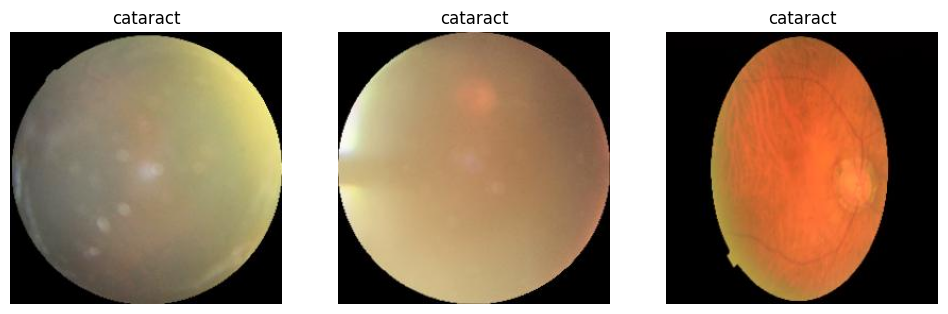

In [7]:
plot_image(1)

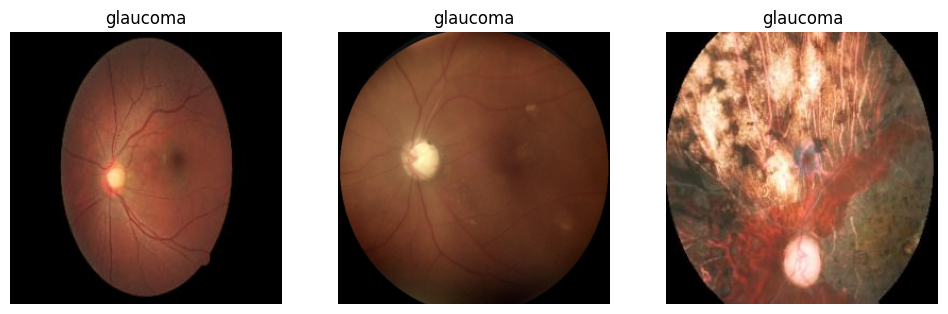

In [8]:
plot_image(0)

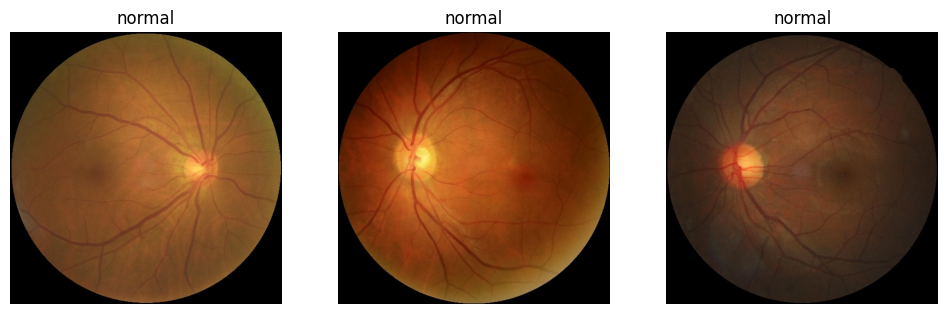

In [9]:
plot_image(2)

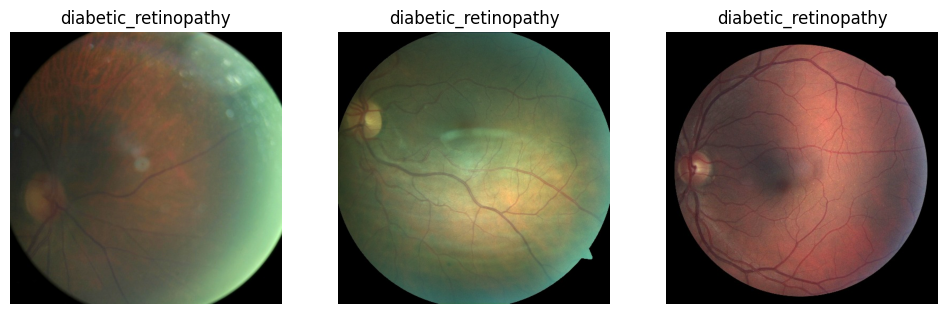

In [10]:
plot_image(3)

In [11]:
# map the labels to the disease type
df['disease_type'] = df['disease_type'].map({0:'glaucoma',1:'cataract',2:'normal',3:'diabetic_retinopathy'})

In [12]:
# check the lebel count to verify it has been mapped
df.disease_type.value_counts()

disease_type
diabetic_retinopathy    1098
normal                  1074
cataract                1038
glaucoma                1007
Name: count, dtype: int64

In [13]:
# randomising the dataset
df1 = df.sample(frac=1).reset_index(drop=True)

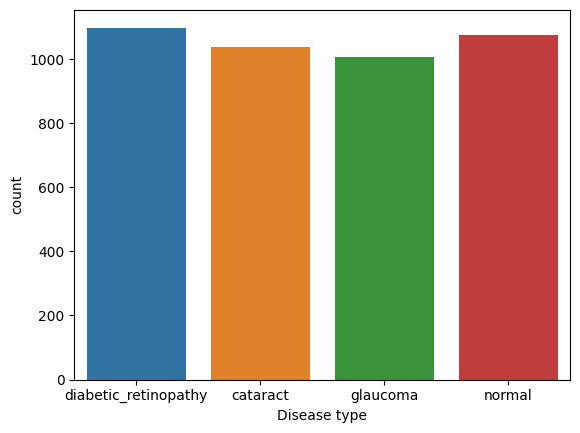

In [14]:
# create a countplot of the disease type
sns.countplot(x = 'disease_type', data = df1)
plt.xlabel("Disease type")
plt.show()

In [15]:
#import necessary libraries for the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

### Model Training

In [16]:
# augumentation of images
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)


In [17]:
# create the train data
train_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = True,
                                          subset = 'training')

Found 3374 validated image filenames belonging to 4 classes.


In [18]:
# create the validation data
valid_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = False,
                                          subset = 'validation')

Found 843 validated image filenames belonging to 4 classes.


In [19]:
labels=[key for key in train_data.class_indices]
num_classes = len(disease_type)

model = keras.Sequential([ 
    layers.Rescaling(1./255, input_shape=(224,224, 3)), 
    layers.Conv2D(16, 3, padding='same', activation='relu'), 
    layers.MaxPooling2D(), 
    layers.Conv2D(32, 3, padding='same', activation='relu'), 
    layers.MaxPooling2D(), 
    layers.Conv2D(64, 3, padding='same', activation='relu'), 
    layers.MaxPooling2D(), 
    layers.Flatten(), 
    layers.Dense(128, activation='relu'), 
    layers.Dense(num_classes,activation='softmax') 
]) 

In [20]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.categorical_crossentropy, 
              metrics=['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [21]:
# fitting the model
his = model.fit( 
  train_data,
    validation_data=valid_data, 
  epochs=15 
)

Epoch 1/15
106/106 [==============================] - 134s 1s/step - loss: 0.8995 - accuracy: 0.6103 - val_loss: 0.6392 - val_accuracy: 0.7367
Epoch 2/15
106/106 [==============================] - 127s 1s/step - loss: 0.5827 - accuracy: 0.7617 - val_loss: 0.5859 - val_accuracy: 0.7722
Epoch 3/15
106/106 [==============================] - 126s 1s/step - loss: 0.4652 - accuracy: 0.8186 - val_loss: 0.4736 - val_accuracy: 0.8090
Epoch 4/15
106/106 [==============================] - 127s 1s/step - loss: 0.4187 - accuracy: 0.8308 - val_loss: 0.4746 - val_accuracy: 0.8066
Epoch 5/15
106/106 [==============================] - 127s 1s/step - loss: 0.3491 - accuracy: 0.8625 - val_loss: 0.4500 - val_accuracy: 0.8339
Epoch 6/15
106/106 [==============================] - 126s 1s/step - loss: 0.3037 - accuracy: 0.8844 - val_loss: 0.4407 - val_accuracy: 0.8363
Epoch 7/15
106/106 [==============================] - 128s 1s/step - loss: 0.2621 - accuracy: 0.8927 - val_loss: 0.4935 - val_accuracy: 0.8399

### Visualizing Model Performance

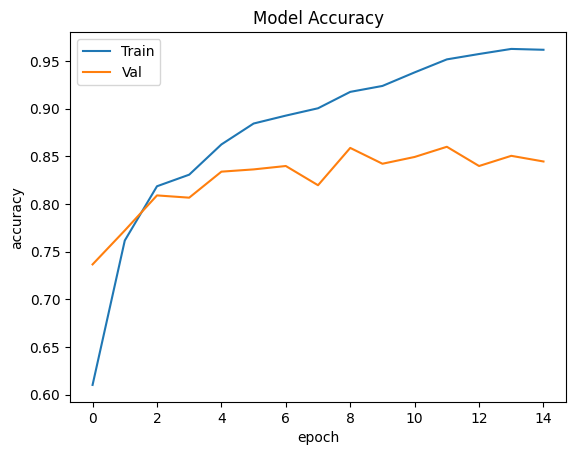

In [22]:
# create a plot of accuracy and val_acuracy for each epoch
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

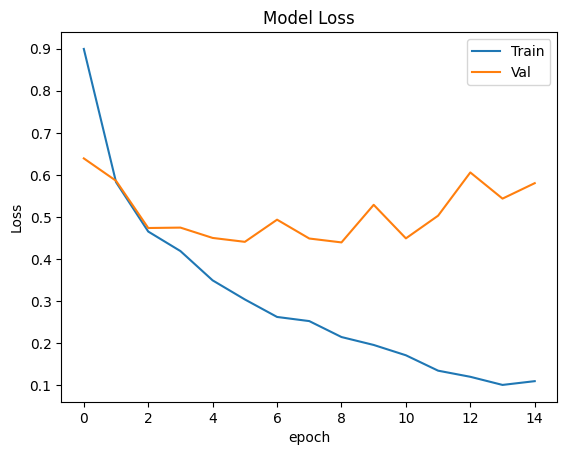

In [23]:
# create a plot of loss and val_loss for each epoch
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

### Model Evaluation

In [24]:
# evaluate the model
y_test = valid_data.classes
y_pred = model.predict(valid_data)
y_pred = np.argmax(y_pred,axis=1)

27/27 [==============================] - 13s 457ms/step


In [25]:
# generate classification report of the model
print(classification_report(y_test,y_pred,target_names = labels))

                      precision    recall  f1-score   support

            cataract       0.86      0.86      0.86       203
diabetic_retinopathy       1.00      0.97      0.98       224
            glaucoma       0.72      0.77      0.75       195
              normal       0.79      0.77      0.78       221

            accuracy                           0.84       843
           macro avg       0.84      0.84      0.84       843
        weighted avg       0.85      0.84      0.85       843



In [26]:
model.save("my_model.h5")